# Pooling-imputation performance from real bead chip data with high density markers

Performs pooling simulation and imputation on data from the chromosome 20 of 1000GP.
Markers have been chosen as the intersection between the real bead chip Illumina Infinium OmniExpress2.5 - 8 Kit
 (https://support.illumina.com/array/array_kits/humanomniexpress2.5-8-beadchip-kit/downloads.html) 
 and the chr20 1000GP data. The samples are randomly assigned to the reference panel or the study population.

Apply pooling simulation on this data, and imputation (run parallel execution): 
**pool and impute bead chip markers only, compute metrics and plot statistics** 
Imputation has been with increased **modelscale=3.0** parameter for trying to account 
for dependency between clustered genotypes

In [10]:
import os

try:
    os.mkdir('/home/camille/PoolImpHuman/data/20200717')
except FileExistsError:
    pass
os.chdir('/home/camille/PoolImpHuman/data/20200717')

In [11]:
print('Configure directory')
%sx ln -s ~/1000Genomes/scripts/VCFPooling/python/omniexpress_20200717.ipynb ./
%sx ln -s ../omniexpress8/InfiniumOmniExpress-chr20-CHROM-POS.txt ./
%sx ln -s /home/camille/PoolImpHuman/data/20200709/ALL.chr20.snps.gt.vcf.gz 

Configure directory


[]

### Prepare experimental VCF file

IMP and REF files are identical to 20200709 (imputation with default parameters)

In [12]:
# study population gt to convert to gl
%sx bcftools view -Oz -o IMP.chr20.snps.gt.vcf.gz -S study.population ALL.chr20.snps.gt.vcf.gz
%sx bcftools index -f IMP.chr20.snps.gt.vcf.gz

[]

In [13]:
print('Impute missing genotypes in the pooled file')
# done on Rackham

Impute missing genotypes in the pooled file


In [14]:
print('Plotting results with bcftools stats')
%sx deactivate
# bcftools stats needs python 2.7
%sx bcftools stats --af-bins 0.01,0.02,0.04,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.98 --collapse snps -S study.population IMP.chr20.pooled.imputed.vcf.gz IMP.chr20.snps.gt.vcf.gz > filestats.vchk
%sx plot-vcfstats -p bcftoolstats -s filestats.vchk

Plotting results with bcftools stats


['Parsing bcftools stats output: filestats.vchk',
 'Warning: Possible version mismatch, the definition line differs',
 '\texpected: # PSC\t[2]id\t[3]sample\t[4]nRefHom\t[5]nNonRefHom\t[6]nHets\t[7]nTransitions\t[8]nTransversions\t[9]nIndels\t[10]average depth\t[11]nSingletons',
 '\tfound:    # PSC\t[2]id\t[3]sample\t[4]nRefHom\t[5]nNonRefHom\t[6]nHets\t[7]nTransitions\t[8]nTransversions\t[9]nIndels\t[10]average depth\t[11]nSingletons\t[12]nHapRef\t[13]nHapAlt\t[14]nMissing',
 'Plotting graphs: python plot.py',
 'plot.py:208: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.',
 'Invalid limit will be ignored.',
 '  ax1.set_xlim(0,1.01)',
 'plot.py:230: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.',
 'Invalid limit will be ignored.',
 '  ax1.set_xlim(0,1.01)',
 'Creating PDF: pdflatex summary.tex >plot-vcfstats.log 2>&1',
 'Finished: bcftoolstats/summary.pdf']

### Compute results with customized metrics

In [15]:
paths = {'beaglegt': {
    'true': '/home/camille/PoolImpHuman/data/20200717/IMP.chr20.snps.gt.vcf.gz',
    'imputed': '/home/camille/PoolImpHuman/data/20200717/IMP.chr20.pooled.imputed.vcf.gz'},
         'beaglegl': {
     'true': '/home/camille/PoolImpHuman/data/20200717/IMP.chr20.snps.gl.vcf.gz',
     'imputed': '/home/camille/PoolImpHuman/data/20200717/IMP.chr20.pooled.imputed.vcf.gz'},
}

In [16]:
import subprocess

convertgtgl = True
if convertgtgl:
    cmd = 'bash ~/PoolImpHuman/bin/bash-scripts/gt_to_gl.sh {} {}'.format(paths['beaglegt']['true'], paths['beaglegl']['true'])
    subprocess.run(cmd, shell=True,)

In [17]:
import pandas as pd
from scripts.VCFPooling.poolSNPs.metrics import quality

In [18]:
qbeaglegt = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')

In [19]:
qbeaglegl = quality.QualityGL(paths['beaglegl']['true'], paths['beaglegl']['imputed'], 0, idx='id')
messbeagle = qbeaglegl.cross_entropy

In [20]:
#qbeaglegl = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')
tabbeaglegl = pd.concat([qbeaglegt.concordance(),
                       qbeaglegt.trueobj.af_info,
                       qbeaglegt.pearsoncorrelation(),
                       qbeaglegt.precision,
                       qbeaglegt.accuracy,
                       qbeaglegt.recall,
                       qbeaglegt.f1_score,
                        qbeaglegl.cross_entropy], axis=1)
dosbeaglegl = qbeaglegt.alleledosage()


In [21]:
tabbeaglegl.head()

,concordance,af_info,r_squared,precision_score,accuracy_score,recall_score,f1_score,cross_entropy
variants,,,,,,,,
rs76553454,1.000000,0.005791,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
rs6076506,0.770833,0.130990,0.081230,0.763365,0.779167,0.779167,0.694992,1.104167
rs6139074,0.525000,0.218251,NaN,0.335434,0.579167,0.579167,0.424824,2.104167
rs1418258,0.450000,0.439497,0.002312,0.333333,0.475000,0.475000,0.355819,2.625000
rs6086616,0.408333,0.571286,0.002222,0.356835,0.454167,0.454167,0.377898,2.729167


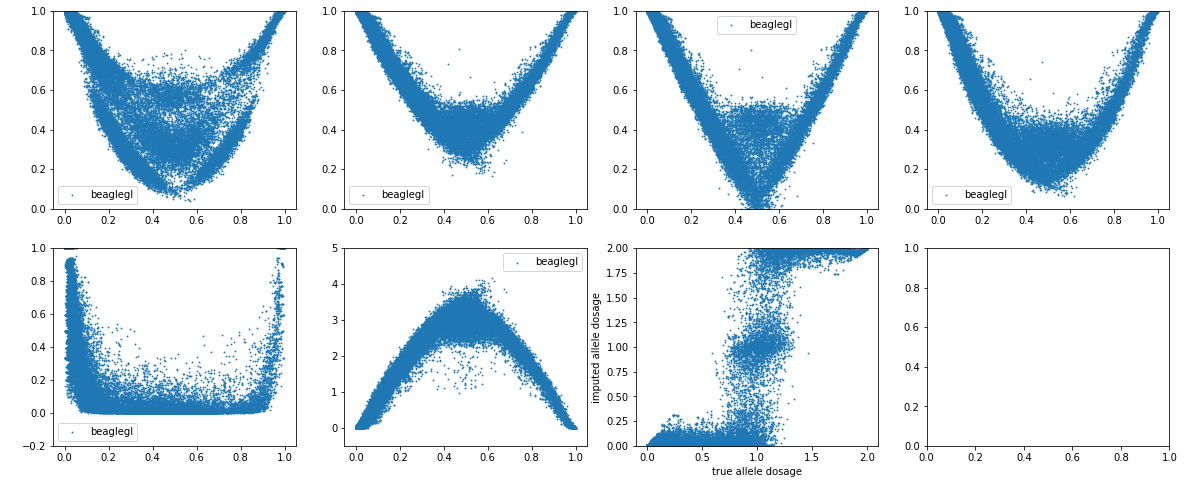

In [22]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5*4, 4*2]
fig, axes = plt.subplots(2, 4)

tabbeaglegl.plot.scatter('af_info', 'precision_score', ax=axes[0, 0], s=0.7, label='beaglegl')
axes[0, 0].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'accuracy_score', ax=axes[0, 1], s=0.7, label='beaglegl')
axes[0, 1].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'concordance', ax=axes[0, 2], s=0.7, label='beaglegl')
axes[0, 2].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'f1_score', ax=axes[0, 3], s=0.7, label='beaglegl')
axes[0, 3].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'r_squared', ax=axes[1, 0], s=0.7, label='beaglegl')
axes[1, 0].set_ylim(-0.2, 1.0)
tabbeaglegl.plot.scatter('af_info', 'cross_entropy', ax=axes[1, 1], s=0.7, label='beaglegl')
axes[1, 1].set_ylim(-0.5, 5.0)
axes[1, 2].scatter(dosbeaglegl[0], dosbeaglegl[1], s=0.7, label='beaglegl')
axes[1, 2].set_xlabel('true allele dosage')
axes[1, 2].set_ylabel('imputed allele dosage')
axes[1, 2].set_ylim(0.0, 2.0)

for ax in axes.flatten()[:-2]:
    # cast color to white 'w' if dark background
    ax.set_xlabel('true alternate allele frequency', color='w')
    ax.set_ylabel(ax.get_ylabel(), color='w')
plt.savefig(os.path.join(os.path.dirname(paths['beaglegt']['imputed']), 'imputation_quality_gtgl.png'))
plt.show()